# Validation Testing
The purpose of this notebook is to test the validation scores of the best found solutions at the end of the GA. The data used in this notebook was generated at hash eb2782bad9d504d0892da01c63c29c5eb5b0d01e.

In [1]:
from figures_markdown_snippets import show_data_instructions

show_data_instructions()


To generate data, run:
- for sklearn
    ```bash
sbatch generate_sklearn_data.sb -n 10 -p 10
    ```
- for dhahri
    ```bash
sbatch generate_dhahri_data.sb -n 20 -p 100 -t 30
    ```
These commands generate files for running genetic search using 10 generations and population size of 10
for the sklearn tutorial and 20 generations with population size of 100
for the Breast Cancer Wisconsin (Diagnostic) Dataset respectively.

The `-n`, `-p`, `-t` flags control number of generations, population sizes, 
and number of trials respectively.

The data generated tracks the top 10 individuals and the population by
each generation and is stored in the corresponding output 
(i.e. the slurm_\[id\].out file).

To extract this data to a csv file, run:
- for the top 10 individuals:
    ```bash
grep "# GEN HOF_index" slurm_[id].out | cut -d '|' -f2 > "filename_1.csv"
    ```
- for the population:
    ```bash
grep "# GEN population_index" slurm_[id].out | cut -d '|' -f2 > "filename_2.csv"
    ```
    
If one has multiple output files that contain different trials of the same
type of GA run, one could try the moving all the relevant files into 
one directory, changing to that directory, and running the following commands instead:
- for the top 10 individuals:
    ```bash
grep "# GEN HOF_index" *.out | cut -d '|' -f2 > "filename_1.csv"
    ```
- for the population:
    ```bash
grep "# GEN population_index" *.out | cut -d '|' -f2 > "filename_2.csv"
    ```


In [2]:
# Path hack so that we can import see library.
import sys, os

sys.path.insert(0, os.path.abspath(".."))

In [3]:
# Set data files path names
hof_filepath = f"../data/0730_dhahri_simple_data/pop_size_100/dhahri_2019_hof_100_100.csv"
population_filepath = f"../0730_dhahri_simple_data/pop_size_100/dhahri_2019_population_100_100.csv"

In [4]:
# Import Helper functions
from figures_helpers import (
    extract_hof_population,
    create_hof_at_gen,
    create_learning_curve,
    plot_learning_curve,
)

In [5]:
# List details about GA runs
num_gen = 100
pop_size = 100
num_trials = 100
hof_size = 10

In [6]:
# Generate hall of fame from the final generation

best_hof, best_hof_individuals = create_hof_at_gen(
    hof_filepath, num_gen, pop_size, num_trials, hof_size, at_gen=num_gen
)

In [7]:
import pandas as pd
import numpy as np
from see import classifiers
from see.classifier_helpers.helpers import generate_train_test_set
from see.classifier_helpers.fetch_data import fetch_wisconsin_data

from sklearn.preprocessing import StandardScaler, label_binarize

# Breast Cancer Data
X, y = fetch_wisconsin_data()

# Preprocess data
X = StandardScaler().fit_transform(X)

# Recreate training, test and validation sets
temp = generate_train_test_set(X, y, test_size=0.2)
validation_set = temp.testing_set
temp = generate_train_test_set(temp.training_set.X, temp.training_set.y, test_size=0.25)
training_set = temp.training_set
testing_set = temp.testing_set

In [8]:
hof_portion = best_hof

# Quick HACK:
# This plot/notebook takes a long time to fully complete running
# if it uses all of the hall of fame members (even for a specific generation).
# For speed, we extract the first five of the hall of fame.
# One should comment out this cell when intending to
# create this figure with all of the data.

# Comment out the line below
# and rerun the notebook from the beginning 
# to properly making figure.

hof_portion = best_hof[:100] # extract first 'n' members

In [9]:
# Generate learning curve Data
train_sizes, train_matrix, validation_matrix = create_learning_curve(training_set, validation_set, hof_portion)

Done with individual:  0
Done with individual:  1
Done with individual:  2
Done with individual:  3
Done with individual:  4
Done with individual:  5
Done with individual:  6
Done with individual:  7
Done with individual:  8
Done with individual:  9
Done with individual:  10
Done with individual:  11
Done with individual:  12
Done with individual:  13
Done with individual:  14
Done with individual:  15
Done with individual:  16
Done with individual:  17
Done with individual:  18
Done with individual:  19
Done with individual:  20
Done with individual:  21
Done with individual:  22
Done with individual:  23
Done with individual:  24
Done with individual:  25
Done with individual:  26
Done with individual:  27
Done with individual:  28
Done with individual:  29
Done with individual:  30
Done with individual:  31
Done with individual:  32
Done with individual:  33
Done with individual:  34
Done with individual:  35
Done with individual:  36
Done with individual:  37
Done with individual: 

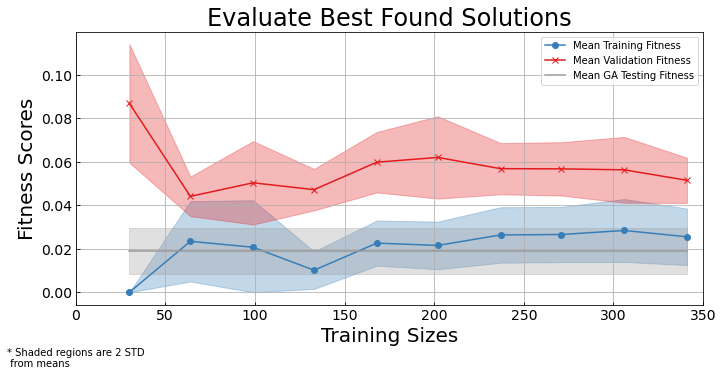

In [15]:
axs = plot_learning_curve(train_sizes, train_matrix, validation_matrix)

# Plot Expected Region during GA
ga_mean = np.repeat(best_hof_individuals[:, 2].mean(), len(train_sizes))
ga_std = np.repeat(best_hof_individuals[:, 2].std(), len(train_sizes))

alpha = 0.3

gray = "#999999"

# Add expected range from data during the GA
axs.fill_between(
    train_sizes, ga_mean - 2 * ga_std, ga_mean + 2 * ga_std, alpha=alpha, color=gray
)

axs.plot(
    train_sizes,
    ga_mean,
    "-",
    color=gray,
    label="Mean GA Testing Fitness",
    linewidth=1.5,
)

# Regenerate the legend
axs.legend()